In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
%reload_ext autoreload

import math
from pathlib import Path
import os
import tempfile
import shutil
from collections import defaultdict
import random

import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


import config
from models import note_classifier, note_detector, note_num_recogniser

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow"

## Find Pedurma Note Marker

In [3]:
def sort_matches(boxes):
    """
    Group bounding boxes into lines and then sort each line from left to right.

    Parameters:
    - boxes: List of tuples, where each tuple represents (x, y, w, h) of a bounding box

    Returns:
    - List of lists, where each sublist contains tuples sorted by x and grouped by line
    """
    # Sort boxes primarily by 'y' to align them into lines
    boxes.sort(key=lambda box: box[1])

    # Group boxes by lines using a vertical threshold
    lines = []
    current_line = []
    current_y = boxes[0][1]

    for box in boxes:
        # If a box's top is within the line vertical range, add it to the current line
        if abs(box[1] - current_y) < 20:  # threshold can be adjusted
            current_line.append(box)
        else:
            # Sort the current line by 'x' before adding to lines
            current_line.sort(key=lambda box: box[0])
            lines.append(current_line)
            current_line = [box]
            current_y = box[1]

    # Don't forget to add the last line
    current_line.sort(key=lambda box: box[0])
    lines.append(current_line)

    # Flatten the list of lists
    flattened_list = [box for line in lines for box in line]
    return flattened_list

def is_note_maker(img, match):
    x, y, w, h = match
    match_img = img[y:y+h, x:x+w]
    # plt.imshow(match_img)
    # plt.show()
    with tempfile.TemporaryDirectory() as tmpdir:
        match_img_fn = Path(tmpdir) / "match.jpg"
        cv2.imwrite(str(match_img_fn), match_img)
        score = note_classifier.predict(match_img_fn)
        return True if score > 0.89 else False
        

def find_pedurma_note_number(image, edged=True, imshow=False, check=True, model=True) -> list[tuple[int, int, int, int]]:
    """Find pedurma note number position in the give image.

    Returns:
        - unique_matches: list of unique matches, i.e., [(x, y, w, h), ...]
    """

    def find_unique_matches(matches):
        def are_points_close(point1, point2, tolerance):
            return math.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2) <= tolerance
        
        unique_matches = []
        tolerance = 10
        
        for current_point in matches:
            if not any(are_points_close(current_point, unique_point, tolerance) for unique_point in unique_matches):
                unique_matches.append(current_point)

        return unique_matches

    if isinstance(image, (Path, str)):            
        img = cv2.imread(str(image_fn))
    else:
        img = image.copy()

    if model:
        matches = note_detector.predict(image)
    else:
        matches = []
        for template_fn in sorted(config.NOTE_MAKER_TEMPLATES_PATH.iterdir()):
            if not template_fn.name.endswith(".png"): continue
            template = cv2.imread(str(template_fn))
            single_matches = match_template(img, template, edged=edged)
            matches.extend(single_matches)

    
    
    if not matches:
        return None

    unique_matches = find_unique_matches(matches)
    if check:
        final_matches = [match for match in unique_matches if is_note_maker(img, match)]
    else:
        final_matches = unique_matches

    if final_matches:
        sorted_matches = sort_matches(final_matches)
    else:
        sorted_matches = []
    

    if imshow:
        for x, y, w, h in sorted_matches:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 1)
        plt.figure(figsize=(20, 15), dpi=100)
        plt.imshow(img)
        plt.show()
    
        
    return sorted_matches

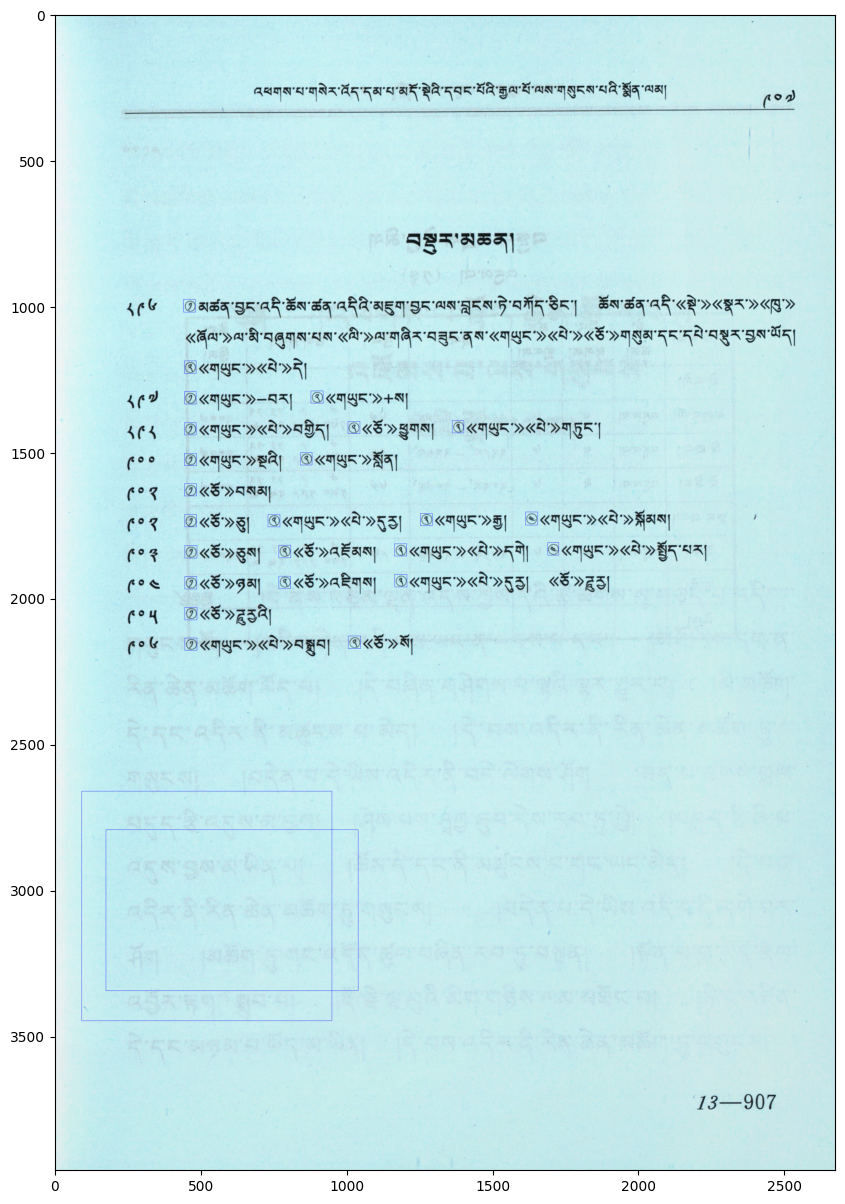

26

In [4]:
image_fn = Path("/Users/10zinten/Developer/OpenPecha/Pedurma/images/W1PD96682/W1PD96682-I1PD96796/text_pages/I1PD967960932.jpg")
matches = find_pedurma_note_number(image_fn, edged=False, imshow=True, check=False)
len(matches)

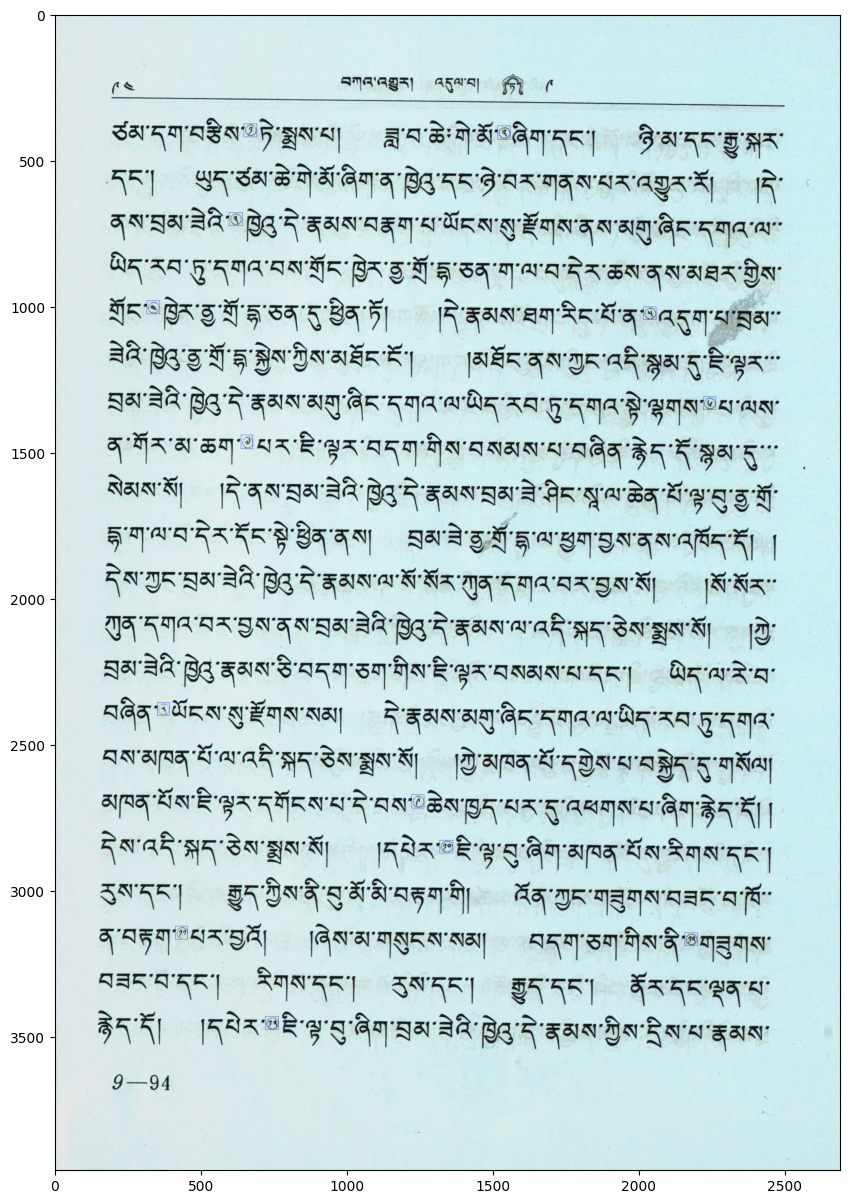

13

In [5]:
image_fn = config.IMAGES_PATH / "W1PD96682" / "W1PD96682-I1PD96792" / "text_pages" / "I1PD967920123.jpg"
matches = find_pedurma_note_number(image_fn, edged=False, imshow=True, check=False)
len(matches)

In [6]:
image_list = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "text_pages"
image_gen = image_list.iterdir()

I1PD959060340.jpg


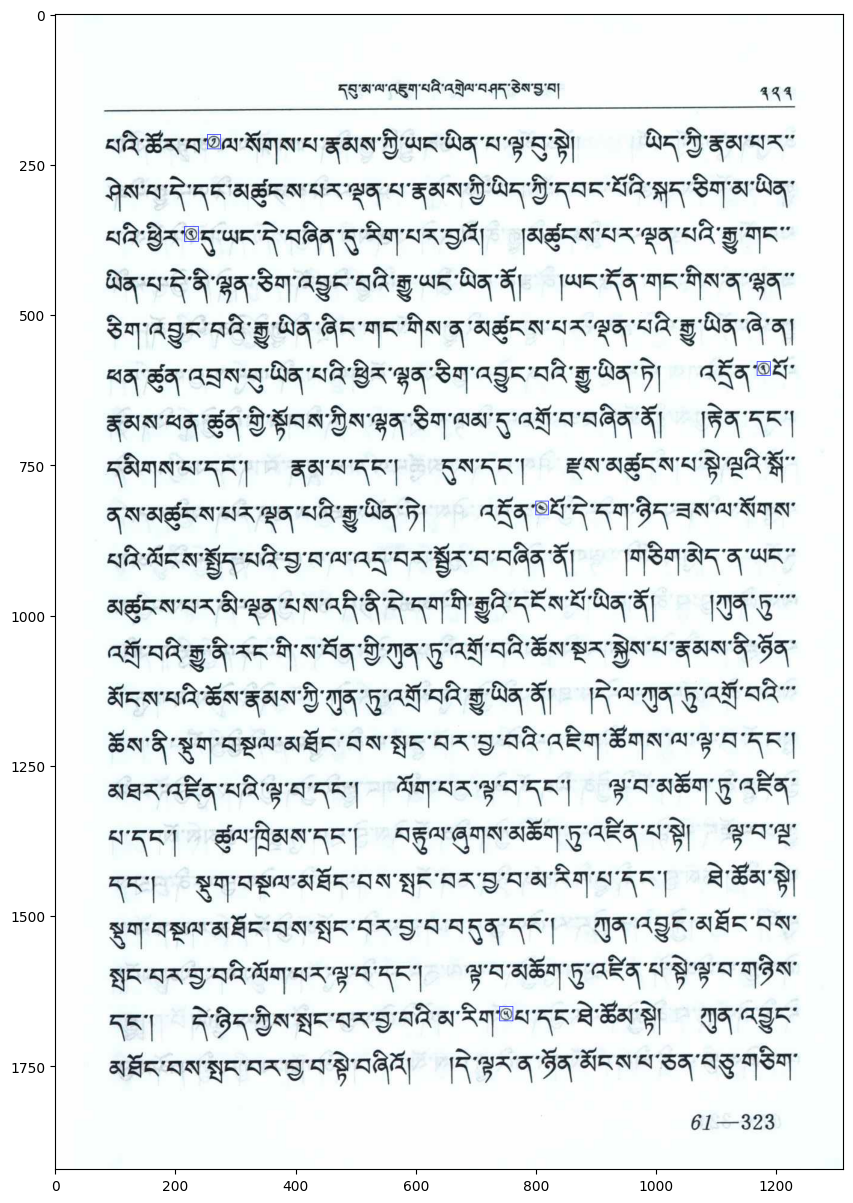

5

In [7]:
image_fn = next(image_gen)
print(image_fn.name)
matches = find_pedurma_note_number(image_fn, imshow=True, check=False)
len(matches)

# Edit Note Marker

In [13]:
def insert_text(image, text, position):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    color = (0, 0, 0) # Blue in BGR
    thickness = 2
    line_type = cv2.LINE_AA
    cv2.putText(image, text, position, font, font_scale, color, thickness, line_type)
    return image

def remove_old_maker(image, position):
    x, y = position
    h, w = 50, 16
    patch = image[0:h, 0:w]
    image[y:y+h, x:x+w] = patch
    return image

def alter_note_maker(image_fn, insert_char=None, output_name="output"):
    image = cv2.imread(str(image_fn))
    matches = find_pedurma_note_number(image, imshow=True)
    if not matches:
        return None
    
    for x, y, w, h in matches:
        image = remove_old_maker(image, (x, y))
        if insert_char:
            insert_text(image, insert_char, (x, y+20))
            output_fn = f"{output_name}_{insert_char}.png"
        else:
            # insert black circle covering the note maker
            cv2.circle(image, (x+7, y+15), 7, (65, 66, 65), -1)
            output_fn = f"{output_name}_circle.png"

    output_path = Path("test") / output_fn
    cv2.imwrite(str(output_path), image)
    plt.imshow(image)
    plt.show()

    return image

In [30]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460249.jpg"
output_name = image_fn.stem
image_new_note_maker = alter_note_maker(image_fn, "", output_name)
image_new_note_maker = alter_note_maker(image_fn, "*", output_name)

[ WARN:0@1248.048] global loadsave.cpp:248 findDecoder imread_('/Users/10zinten/Developer/OpenPecha/Pedurma/images/W1PD95844/W1PD95844-I1PD95846/images/I1PD958460249.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

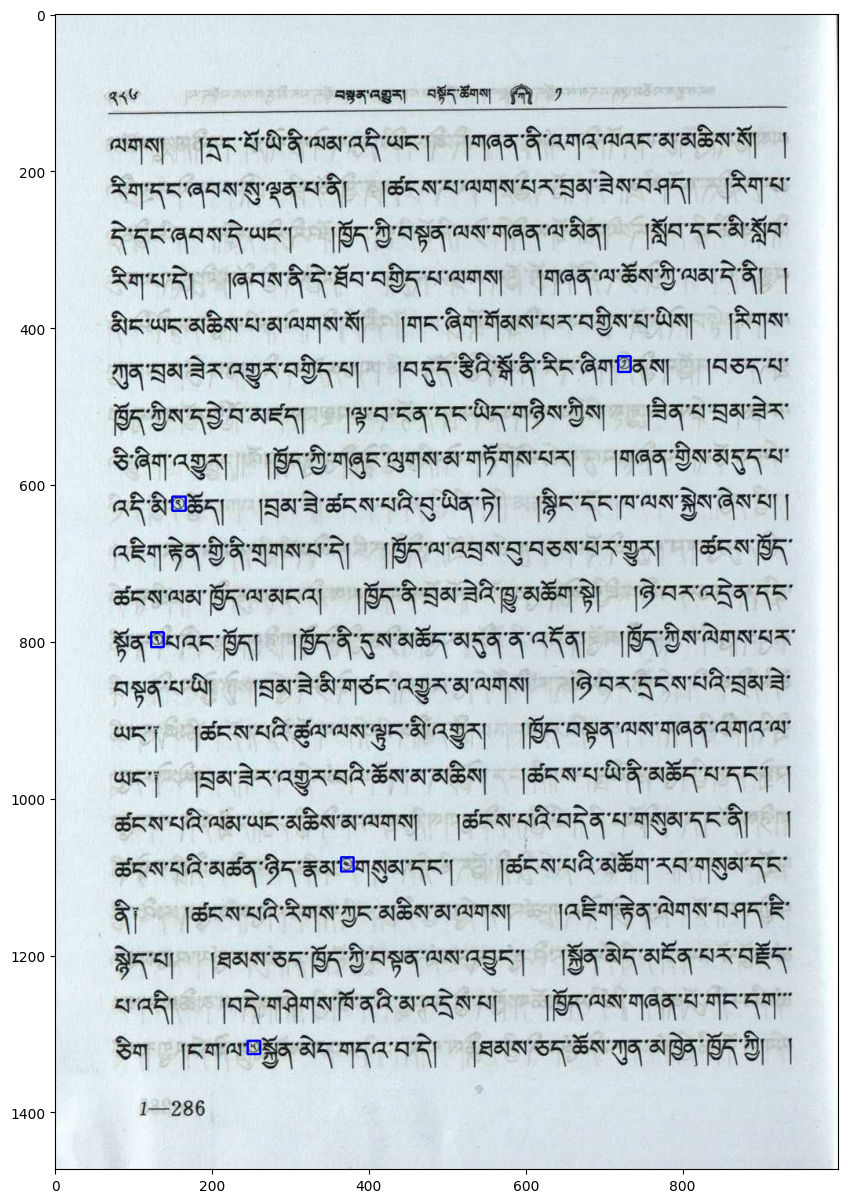

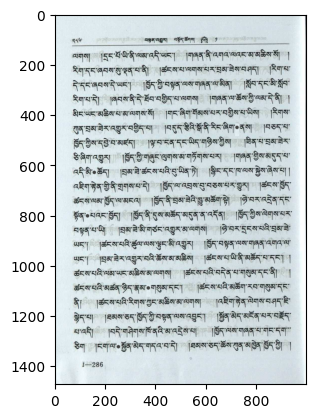

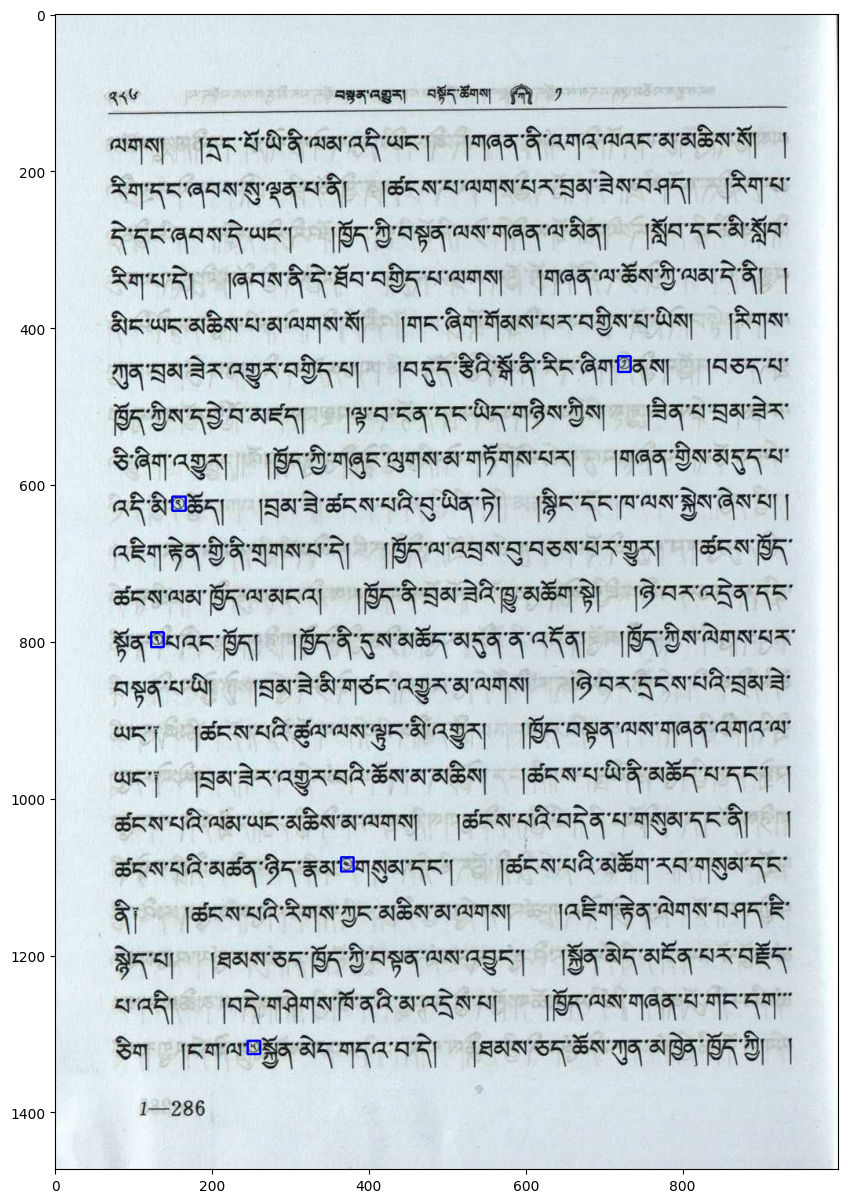

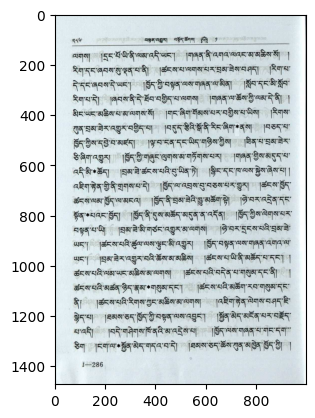

In [37]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460324.jpg"
output_name = image_fn.stem
image_new_note_maker = alter_note_maker(image_fn, "", output_name)
image_new_note_maker = alter_note_maker(image_fn, "*", output_name)

# Generate Yolo Training

### 1. Create inital training data with existing model

In [5]:
yolo_training_data_path = config.NOTE_DETECTION_TRAINING_DATA / "data_v3"
uncleaned_data_path = yolo_training_data_path / "uncleaned"

uncleaned_images_path = uncleaned_data_path / "images"
uncleaned_images_path.mkdir(parents=True, exist_ok=True)
uncleaned_labels_path = uncleaned_data_path / "labels"
uncleaned_labels_path.mkdir(parents=True, exist_ok=True)

In [9]:
def generate_yolo_training_data_for_dir(images_path, prefix, page_type):
    dest_images_path = uncleaned_images_path / page_type
    dest_images_path.mkdir(parents=True, exist_ok=True)
    labels_path = uncleaned_labels_path / page_type
    labels_path.mkdir(parents=True, exist_ok=True)
    step = 0
    for image_fn in (pbar := tqdm(list(images_path.iterdir()))):
        pbar_descp = f"{images_path.parent.name.split('-')[-1]}/{images_path.name[0]}"
        pbar.set_description(pbar_descp)
        if page_type == "text_pages":
            matches_images_path = uncleaned_data_path / "matches" / f"{prefix}_{image_fn.stem}"
            matches_images_path.mkdir(parents=True, exist_ok=True)
        if step > 5000: break
        if not image_fn.name.endswith(".jpg"): continue
        dest_image_fn = dest_images_path / f"{prefix}_{image_fn.name}"
        shutil.copy(str(image_fn), str(dest_image_fn))
        label_fn =  labels_path / f"{prefix}_{image_fn.stem}.txt"
        if label_fn.is_file(): continue
        image = cv2.imread(str(image_fn))
        img_height, img_width, _ = image.shape
        matches = find_pedurma_note_number(image, check=False)
        if not matches: continue
        with label_fn.open("w+") as f:
            for i, (x, y, mw, mh) in enumerate(matches):
                if page_type == "text_pages":
                    match_img = image[y:y+mh, x:x+mw]
                    match_img_name = f"{i+1:02}_{dest_image_fn.stem}.jpg"
                    match_img_fn = matches_images_path / match_img_name
                    cv2.imwrite(str(match_img_fn), match_img)
                else:
                    match_img_name = "" 
                x_center = round(((2*x+mw) / 2) / img_width, 6)
                y_center = round(((2*y+mw) / 2) / img_height, 6)
                w = round(mw / img_width, 6)
                h = round(mh / img_height, 6)
                label = f"{match_img_name} 0 {x_center} {y_center} {w} {h}".strip() + "\n"
                f.write(label)
        step += 1

In [10]:
def generate_yolo_training_data(works_path):
    for work_path in works_path.iterdir():
        if not work_path.is_dir(): continue
        print("Processing", work_path.name, "...")
        for vol_path in tqdm(list(work_path.iterdir())):
            if not vol_path.is_dir(): continue
            text_pages_path = vol_path / "text_pages"
            generate_yolo_training_data_for_dir(
                images_path=text_pages_path,
                prefix=work_path.name, 
                page_type=text_pages_path.name
            )
            note_pages_path = vol_path / "note_pages"
            generate_yolo_training_data_for_dir(
                images_path=note_pages_path,
                prefix=work_path.name,
                page_type=note_pages_path.name
            )

In [95]:
generate_yolo_training_data(config.IMAGES_PATH)

Processing W1PD96682 ...


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/701 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/657 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

Corrupt JPEG data: 248 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Processing W1PD95844 ...


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1371 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/1309 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/1551 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/1538 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/1777 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/1727 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

In [12]:
# image_sizes = []
# for img_fn in images_path.iterdir():
#     if not img_fn.name.endswith(".jpg"): continue
#     h, w, _ = cv2.imread(str(img_fn)).shape
#     image_sizes.append(h)

# print(min(image_sizes))

### 3. Detect Page containing False Negative Detection

In [6]:
notes_path = uncleaned_data_path / "matches"

In [7]:
def contains_false_negative(page_path, max_notes=15):
    notes = list(page_path.glob("*.jpg"))
    if len(notes) > max_notes: return True
    for note_fn in notes:
        gt = int(note_fn.name[:2])
        pred = int(note_num_recogniser.predit(note_fn))
        if gt != pred:
            return True
    return False

def process(notes_path, imshow=False):
    false_neg_pages = []
    pages = list(notes_path.iterdir())
    for page_path in tqdm(pages):
        if not page_path.is_dir(): continue
        if contains_false_negative(page_path):
            false_neg_pages.append(page_path.name)
    return false_neg_pages, len(pages)

In [8]:
false_neg_pages, total_pages = process(notes_path)

  0%|          | 0/15142 [00:00<?, ?it/s]

In [9]:
len(false_neg_pages) / 15142

0.21668207634394399

In [10]:
len(list((uncleaned_data_path / "images" / "text_pages").iterdir()))

15132

In [11]:
len(false_neg_pages), false_neg_pages[0]

(3281, 'W1PD96682_I1PD967860682')

### 3. Create Cleaned Dataset

Filter out all the page containing false negative page

In [14]:
cleaned_data_path = yolo_training_data_path / "cleaned"

cleaned_images_path = cleaned_data_path / "images"
cleaned_images_path.mkdir(parents=True, exist_ok=True)
cleaned_labels_path = cleaned_data_path / "labels"
cleaned_labels_path.mkdir(parents=True, exist_ok=True)

In [31]:
def clean_labels(label_fn):
    cleaned_content = ""
    for label in label_fn.read_text().splitlines():
        cleaned_label = " ".join(label.split()[1:])
        cleaned_content += cleaned_label + "\n"
    label_fn.write_text(cleaned_content)
    
def create_cleaned_dataset(false_neg_pages):
    uncleaned_text_images_path = uncleaned_images_path / "text_pages"
    uncleaded_note_pages_path = uncleaned_images_path / "note_pages"
    
    for page_fn in tqdm(list(uncleaned_text_images_path.iterdir())):
        if page_fn.stem in false_neg_pages: continue
        page_img_name = f"{page_fn.stem}.jpg"
        page_label_name = f"{page_fn.stem}.txt"
        page_img_path_uncleaned = uncleaned_images_path / "text_pages" / page_img_name
        page_labels_path_uncleaned = uncleaned_labels_path / "text_pages" / page_label_name

        if not page_img_path_uncleaned.is_file() or not page_labels_path_uncleaned.is_file():
            continue
            
        dest_page_img_path_cleaned = cleaned_images_path / page_img_name
        shutil.move(str(page_img_path_uncleaned), str(dest_page_img_path_cleaned))

        page_labels_path_uncleaned = uncleaned_labels_path / "text_pages" / page_label_name
        dest_page_labels_path_cleaned = cleaned_labels_path / page_label_name
        shutil.move(str(page_labels_path_uncleaned), str(dest_page_labels_path_cleaned))
        clean_labels(dest_page_labels_path_cleaned)

In [32]:
create_cleaned_dataset(false_neg_pages)

  0%|          | 0/15123 [00:00<?, ?it/s]

In [34]:
def move_all_note_pages_to_cleaned_data():
    uncleaded_note_pages_path = uncleaned_images_path / "note_pages"
    for page_fn in tqdm(list(uncleaded_note_pages_path.iterdir())):
        page_img_name = f"{page_fn.stem}.jpg"
        page_label_name = f"{page_fn.stem}.txt"
        page_img_path_uncleaned = uncleaned_images_path / "note_pages" / page_img_name
        page_labels_path_uncleaned = uncleaned_labels_path / "note_pages" / page_label_name

        if not page_img_path_uncleaned.is_file() or not page_labels_path_uncleaned.is_file():
            continue
            
        dest_page_img_path_cleaned = cleaned_images_path / page_img_name
        shutil.move(str(page_img_path_uncleaned), str(dest_page_img_path_cleaned))

        dest_page_labels_path_cleaned = cleaned_labels_path / page_label_name
        shutil.move(str(page_labels_path_uncleaned), str(dest_page_labels_path_cleaned))

move_all_note_pages_to_cleaned_data()

  0%|          | 0/1648 [00:00<?, ?it/s]

### 4. Split the cleaned dataset into train and valid

In [39]:
yolo_training_dataset_path = yolo_training_data_path / "data_v3"

train_path = yolo_training_dataset_path /  "train"
train_images_path = train_path / "images"
train_images_path.mkdir(parents=True, exist_ok=True)
train_labels_path = train_path / "labels"
train_labels_path.mkdir(parents=True, exist_ok=True)

valid_path = yolo_training_dataset_path / "valid"
valid_images_path = valid_path / "images"
valid_images_path.mkdir(parents=True, exist_ok=True)
valid_labels_path = valid_path / "labels"
valid_labels_path.mkdir(parents=True, exist_ok=True)

In [40]:
def split_cleaned_data():
    pages = [page.stem for page in cleaned_images_path.iterdir()]
    random.shuffle(pages)
    train_ds = pages[:int((len(pages)+1)*.80)]
    valid_ds = pages[int((len(pages)+1)*.80):]
    
    for page in train_ds:
        page_img_name = f"{page}.jpg"
        page_label_name = f"{page}.txt"
        page_img_fn = cleaned_images_path / page_img_name
        dest_page_img_fn = train_images_path / page_img_name
        shutil.move(str(page_img_fn), str(dest_page_img_fn))
        page_label_fn = cleaned_labels_path / page_label_name
        dest_page_label_fn = train_labels_path / page_label_name
        shutil.move(str(page_label_fn), str(dest_page_label_fn))

    for page in valid_ds:
        page_img_name = f"{page}.jpg"
        page_label_name = f"{page}.txt"
        page_img_fn = cleaned_images_path / page_img_name
        dest_page_img_fn = valid_images_path / page_img_name
        shutil.move(str(page_img_fn), str(dest_page_img_fn))
        page_label_fn = cleaned_labels_path / page_label_name
        dest_page_label_fn = valid_labels_path / page_label_name
        shutil.move(str(page_label_fn), str(dest_page_label_fn))

split_cleaned_data()

## Generate Note Classifier Training Data

In [14]:
def gen_note_classifier_training_data(images_path):
    data_save_path = config.NOTE_CLASSIFIER_TRAINING_DATA / f"todo_{images_path.parent.parent.name}"
    data_save_path.mkdir(parents=True, exist_ok=True)
    total_matches = 0
    for image_fn in images_path.iterdir():
        if total_matches > 250: break
        if not image_fn.name.endswith(".jpg"): continue
        print(f"Running {image_fn.name} ...")
        image = cv2.imread(str(image_fn))
        matches = find_pedurma_note_number(image, check=False)
        if list(data_save_path.glob(f"{image_fn.stem}_*")): continue
        if not matches: continue
        total_matches += len(matches)
        for i, (x, y, w, h) in enumerate(matches):
            match = image[y:y+h, x:x+w]
            match_name = f"{image_fn.stem}_{i+1:02}.jpg"
            match_path = data_save_path / match_name
            cv2.imwrite(str(match_path), match)

In [ ]:
images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "note_pages"
gen_note_classifier_training_data(images_path)

## Generate Note Number Recognittion Dataset

In [11]:
def gen_note_num_recognition_dataset(notes_path, min_note_num=16, max_note_num=100):
    data_save_path = config.NOTE_NUM_RECOGNITION_DATASET / "data"
    data_save_path.mkdir(parents=True, exist_ok=True)
    for vol_path in tqdm(list(notes_path.iterdir())):
        if not vol_path.is_dir(): continue
        for note_fn in vol_path.iterdir():
            if not note_fn.name.endswith(".jpg"): continue
            note_num = int(note_fn.name[:2])
            if min_note_num <= note_num < max_note_num:
                note_num_dir = data_save_path / str(note_num)
                note_num_dir.mkdir(parents=True, exist_ok=True)
                dest_note_fn = note_num_dir / note_fn.name
                shutil.copy(str(note_fn), str(dest_note_fn))

In [12]:
notes_path = uncleaned_data_path / "matches"
gen_note_num_recognition_dataset(notes_path, 15, 16)

  0%|          | 0/15142 [00:00<?, ?it/s]

In [37]:
def clean_step_01(images_path):
    data_save_path = config.NOTE_NUM_RECOGNITION_DATASET / "todo"
    data_save_path.mkdir(parents=True, exist_ok=True)
    counter = defaultdict(int)
    for image_fn in images_path.iterdir():
        if not image_fn.name.endswith(".jpg"): continue
        print(f"Running {image_fn.name} ...")
        note_num_list = list(data_save_path.glob(f"{image_fn.stem}_*"))
        if not note_num_list or len(note_num_list) <= 8: continue
        dest_dir = data_save_path / f"{len(note_num_list)}_{counter[len(note_num_list)]:04}"
        dest_dir.mkdir(parents=True, exist_ok=True)
        for note_num_fn in note_num_list:
            dest_note_num_fn = dest_dir / note_num_fn.name
            shutil.move(str(note_num_fn), str(dest_note_num_fn))
        counter[len(note_num_list)] += 1

In [ ]:
# images_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "images"
# clean_step_01(images_path)

In [12]:
data_save_path = config.NOTE_NUM_RECOGNITION_DATASET / "todo"
for class_path in data_save_path.iterdir():
    if class_path.name.startswith(".DS_Store"): continue
    print(class_path.name)
    for note_fn in class_path.iterdir():
        if note_fn.name.startswith(".DS_Store"): continue
        h, w, _ = cv2.imread(str(note_fn)).shape
        if h > 50 or w > 50:
            print("detection error:", note_fn)
            note_fn.unlink()
            print(note_fn)

In [ ]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95906" / "images" / "I1PD959060188.jpg"
image = cv2.imread(str(image_fn))
matches = find_pedurma_note_number(image, check=False)
sorted_matches = sort_matches(matches)
for i, (x, y, w, h) in enumerate(sorted_matches):
    match = image[y:y+h, x:x+w]
    
    print(i+1, x, y)
    plt.imshow(match)
    plt.show()
    